# 2CIMPL

Double-<b>C</b>ross-linking, <b>IM</b>munoprecipitation, and <b>P</b>roximity <b>L</b>igation ([2CIMPL](to_be_added)) is a method for finding RNA-RNA interactions. This notebook parses and analyzes 2CIMPL sequencing data to identify where links are occuring, and presents a pipeline to create corresponding images and correlations.

The data and methods here are tailored to Influenza virus; however, they could be modified for other purposes. The pipeline relies on a slightly modified version of [aligater](https://github.com/timbitz/Aligater), an analysis package originally developed for use in [LIGR](https://www.ncbi.nlm.nih.gov/pubmed/27184080).

# Setup

The following software is required to run this pipeline:

- **Perl v5** (Used in Aligater)
- **Python 3** & **ipython**
- **[bowtie2](http://bowtie-bio.sourceforge.net/bowtie2/manual.shtml)** (Used in Aligater)
- **[Circos](http://circos.ca/software/download/)** (Used to generate Circos plots)
- **[BEDTools](https://bedtools.readthedocs.io/en/latest/content/installation.html)** (Used to generate bedgraphs for circos plots)
- **[PEAR](https://www.h-its.org/downloads/pear-academic/)**

## Parameters you'll need or may want to modify

In [1]:
path_to_files = ('../raw_files/')
output_dir = '.' # This will output to the notebook's directory
threads = 2 # Number of threads to use for bowtie2
keep_files_gzipped = True

# Upper Triangle Plot resolution (number of nucleotides grouped
# into each square for comparing occurrence of links)
plots_bin_size = 50

# number of nucleotides grouped together for comparing links in
# Pearson correlations
pearson_bin_size = plots_bin_size

# number of nucleotides grouped together for comparing links
# between replicates for Circos plots
shared_bin_size = 25 # for links shared between reps

# Don't change the order, but feel free to change the name.
samples = [
    'WSN_1',
    'WSN_2',
    'NP_Hotspot_1',
    'NP_Hotspot_2'
]

## Load Libraries

In [2]:
from Bio.Seq import Seq

import gzip
import math
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sys

sys.path.insert(0, '../plots_lib/lib')
import contactPlots
import jpk_util
import circos

## Parameters

In [3]:
# Used in the PEAR step. Should not be changed for this data.
paired_end = {x:True for x in samples}

input_files = {
    samples[0]:(path_to_files + 'WSN_1_R1.fastq.gz',
                path_to_files + 'WSN_1_R2.fastq.gz'),
    samples[1]:(path_to_files + 'WSN_2_R1.fastq.gz',
                path_to_files + 'WSN_2_R2.fastq.gz'),
    samples[2]:(path_to_files + 'WSN_NP_Hotspot_1_R1.fastq.gz',
                path_to_files + 'WSN_NP_Hotspot_1_R2.fastq.gz'),
    samples[3]:(path_to_files + 'WSN_NP_Hotspot_2_R1.fastq.gz',
                path_to_files + 'WSN_NP_Hotspot_2_R2.fastq.gz'),
}

strains = {
    samples[0]:'WSN',
    samples[1]:'WSN',
    samples[2]:'NP_Hotspot',
    samples[3]:'NP_Hotspot'
}
unique_strains = set([x for x in strains.values()])

# Both WSN and NP Hotspot have the same size chromosomes
chroms = {x:'../genome/WSN/WSN.chrom.sizes' for x in samples}

# bowtie index for aligater
bowtie_indices = {
    samples[0]:'../genome/WSN/WSN',
    samples[1]:'../genome/WSN/WSN',
    samples[2]:'../genome/WSN_NP_Hotspot_Mut/WSN_NP_Hotspot',
    samples[3]:'../genome/WSN_NP_Hotspot_Mut/WSN_NP_Hotspot'
}

# File Names
paired_files = {x:(output_dir + '/pear/' + x + '_paired.assembled.fastq') for x in samples}
collapsed_files = {x:(output_dir + '/data/' + x + '_collapsed.fastq') for x in samples}
aligned_files = {x:(output_dir + '/aligater/' + x + '_aln.bam') for x in samples}
junction_files = {x:(output_dir + '/aligater/' + x + '_junctions.lig') for x in samples}

if keep_files_gzipped:
    paired_files = {x:paired_files[x] + '.gz' for x in samples}
    collapsed_files = {x:collapsed_files[x] + '.gz' for x in samples}

# Pair Reads with [PEAR](https://www.h-its.org/downloads/pear-academic/)

PEAR is available under the creative commons license, making it free for academic use. It also has the benefit of dealing with paired-end reads that are short enough that they pass through the end of the mate (unlike [FLASh](https://ccb.jhu.edu/software/FLASH/), an alternative that I tried).

Example diagram of most of our data:

```
Mate 1:  [5' Illum. Adapter]--------------->-3'

Mate 2:             5'<---------------[3' Illum. Adapter]

Actual Read:                ----------
```

I believe this also why trying to pass in paired-end reads to bowtie2 doesn't provide the same results. PEAR seems the most reliable here, as the output from pairing with PEAR seems to reflect what the reads should be, with both adapters on either end removed.


### Parameters Used

`-b 20` lowers the PHRED quality check from 33 to 20. This doesn't have too large of an impact, but was used since not all of our data was top quality.

`-y 1G` allows PEAR to use up to 1GB of RAM. This is strictly for computational convenience, removing it should have no effect.

In [4]:
!mkdir -p $output_dir"/pear"

for sample in samples:
    if (paired_end[sample]):
        r1 = input_files[sample][0]
        r2 = input_files[sample][1]
        out_f = paired_files[sample]
        if out_f[-3:] == '.gz':
            out_f = out_f[:-3]
            
        # Will output info to 'pear/sample_paired.log'
        log_name = out_f.replace('.assembled.fastq', '.log')
        if (not os.path.isfile(out_f) and
            not os.path.isfile(out_f + '.gz')):
            prefix = log_name.replace('.log', '')
            !touch $log_name
            !../pear -b 20 -j $threads -y 1G -f $r1 -r $r2 -o $prefix 2>&1> $log_name

        !cat $log_name
        print()
        if (keep_files_gzipped and not os.path.isfile(paired_files[sample])):
            !gzip $out_f

 ____  _____    _    ____ 
|  _ \| ____|  / \  |  _ \
| |_) |  _|   / _ \ | |_) |
|  __/| |___ / ___ \|  _ <
|_|   |_____/_/   \_\_| \_\

PEAR v0.9.11 [Nov 5, 2017]

Citation - PEAR: a fast and accurate Illumina Paired-End reAd mergeR
Zhang et al (2014) Bioinformatics 30(5): 614-620 | doi:10.1093/bioinformatics/btt593

Forward reads file.................: ../raw_files/WSN_1_R1.fastq.gz
Reverse reads file.................: ../raw_files/WSN_1_R2.fastq.gz
PHRED..............................: 20
Using empirical frequencies........: YES
Statistical method.................: OES
Maximum assembly length............: 999999
Minimum assembly length............: 50
p-value............................: 0.010000
Quality score threshold (trimming).: 0
Minimum read size after trimming...: 1
Maximal ratio of uncalled bases....: 1.000000
Minimum overlap....................: 10
Scoring method.....................: Scaled score
Threads............................: 2

Allocating memory..................: 

# Remove PCR Duplicates

Script provided by the [CLIP Toolkit](https://github.com/chaolinzhanglab/ctk). It just executes a series of UNIX commands to remove exact duplicates while maintaining fastq format. Since we don't use barcodes, there's no way to tell whether duplicates are the result of PCR or true exact copies.

In [5]:
!mkdir -p $output_dir/data
for sample in samples:
    in_f = paired_files[sample]
    out_f = collapsed_files[sample]
    if out_f[-3:] == '.gz':
        out_f = out_f[:-3]
    if (not os.path.isfile(out_f) and
        not os.path.isfile(out_f + '.gz')):
        script = '../fastq2collapse.pl'
        !perl $script -v $in_f $out_f
        
    if (keep_files_gzipped and not os.path.isfile(collapsed_files[sample])):
        !gzip $out_f

# [Aligater](https://github.com/timbitz/Aligater)

Aligater is a "Software suite for detection/analysis of chimeric RNAs from LIGR-seq data". Because our results are extremely similar to LIGR results (chimeric RNA ligated together without adapters), we decided to leverage their program.

We made a few small modifications to the software to accommodate the differences in our protocol & data (see below, as the changes only affected the junction discovery portion). This mostly consisted in adding additional parameters to the software. We tried to comment any modifications to the body of the code, so it should be clear where changes were made.

We decided not to pull & commit these changes to the Aligater repository since it's for a specialized case, opting instead to include the modified version in this repository.

## Align using bowtie2

In [6]:
!mkdir -p $output_dir"/aligater/"
aligater_script = '../aligater/aligater'
for sample in samples:
    aligned_file = aligned_files[sample]
    bowtie_log = aligned_file.replace('.bam', '.log')
    if not os.path.isfile(aligned_file):
        bt2_idx = bowtie_indices[sample]
        in_f = collapsed_files[sample]
        
        # Aligater throws an error if the input file is gzipped
        if in_f[-3:] == '.gz':
            if os.path.isfile(in_f):
                !gunzip $in_f
            in_f = in_f[:-3]
        
        print('Aligning ' + sample + ' to ' + strains[sample])
        params = ' '.join([
            'align',
            '-p', str(threads),
            '--bam',
            '-x', bt2_idx,
            in_f
        ])
        !touch $bowtie_log
        !perl $aligater_script $params 1> $aligned_file 2> $bowtie_log

        if (keep_files_gzipped and not os.path.isfile(collapsed_files[sample])):
            !gzip $in_f
    !cat $bowtie_log
    print()

4764575 reads; of these:
  4764575 (100.00%) were unpaired; of these:
    3910367 (82.07%) aligned 0 times
    811449 (17.03%) aligned exactly 1 time
    42759 (0.90%) aligned >1 times
17.93% overall alignment rate

6012356 reads; of these:
  6012356 (100.00%) were unpaired; of these:
    4702915 (78.22%) aligned 0 times
    1258051 (20.92%) aligned exactly 1 time
    51390 (0.85%) aligned >1 times
21.78% overall alignment rate

41404644 reads; of these:
  41404644 (100.00%) were unpaired; of these:
    22884559 (55.27%) aligned 0 times
    18107149 (43.73%) aligned exactly 1 time
    412936 (1.00%) aligned >1 times
44.73% overall alignment rate

2285892 reads; of these:
  2285892 (100.00%) were unpaired; of these:
    1462431 (63.98%) aligned 0 times
    797906 (34.91%) aligned exactly 1 time
    25555 (1.12%) aligned >1 times
36.02% overall alignment rate



## Junction Discovery

### Updated Aligater detect parameters

We made several modifications to Aligater's `detect` program to make it more flexible for our purposes. Specifically: 
1. `--ss` is a parameter to enforce that both sections of the hybrid must come from the same strand.
2. `--overlap` allows more overlap than a single nucleotide when deciding whether two alignments on a read qualify as separate (i.e. a hybrid).
3. `--gap` allows for a larger gap between nucleotides (though I don't think we want to use this).
4. I updated `--noanti` to actually take a parameter as 0 or 1, since before it was defaulting to 1 and didn't take an argument to change it.

We allowed up to 7 nucleotides of overlap between chimeric reads.

We used `--pen=24` for the hybrid score. This is used to decide whether the quality score of the hybrid is better than the quality score of another alignment. 

For a hybrid, the scores that are compared at the end are computed by: `score(alignment_1) + score(alignment_2) - hybrid`. The idea is that we want to make sure that neither score(alignment_1) nor score(alignment_2) can outweigh this, but if there's another alignment that extends for most of the read (alignment_3), then that might be the *actual* alignment, rather than a hybrid, and we'd want that to outway the above calculation.

24 is the default, but it explicitly says in the Aligater code that it should be optimized. I'm not entirely sure how to do that, so I left it as the default.

In [7]:
params = (' '.join([
    '--antipen=0', # param I added to not penalize antisense strand. Default is -24
    '--noanti=0', # param I updated to allow antisense strand. Default is 1
    '--pen=24', # hybrid penalty. Default is -24
    '--ss=1', # param I added to require same-strandedness in hybrids. Default is 0
    '--overlap=7'])) # param I added to allow more overlap between alignments. Default is 1

for sample in samples:
    junction_file = junction_files[sample]
    if not os.path.isfile(junction_file):
        aligned_file = aligned_files[sample]
        !samtools view -h $aligned_file | perl $aligater_script detect $params > $junction_file 2>/dev/null
        
        # remove extraneous files produced by Aligater
        !rm Output_*.bam

# Generate [Circos](http://circos.ca/), [Sashimi](https://software.broadinstitute.org/software/igv/Sashimi), and [Upper Triangle Plots*](http://promoter.bx.psu.edu/hi-c/index.html)

\*See the hiC representations in the link.

Circos is a command-line tool driven by configuration files to display inter-chromosomal (or in this case, inter-segmental) interactions. I've created a generic template in the parent plot_lib folder where you just need to change the variables at the top to change the data inside.

We no longer use Sashimi plots due to an abundance of intrasegmental interactions (which makes them very messy and unhelpful in the small IAV genome). I create them below just in case though.

Instead, we use upper triangle plots, or **contact plots**. We got this idea from figures used in hiC papers. The linked Yue lab has an example in their slideshow, as well as tools for creating them from hiC data. 

### Parsing the Aligater Link File:

See the .lig file format in the [Aligater](https://github.com/timbitz/Aligater#file-formats) README for a full layout, however the important parts are:

`$6` = first segment : second segment

`$14` = end of the first : start of the second

`$16` = length of first : length of second

The output file that we'll use to derive inter- / intra-segmental links for Circos and Sashimi / Upper Triangle plots (respectively) will have a format that looks like:

HA&nbsp;&nbsp;&nbsp;&nbsp;
10&nbsp;&nbsp;&nbsp;&nbsp;
26&nbsp;&nbsp;&nbsp;&nbsp;
PB2&nbsp;&nbsp;&nbsp;&nbsp;
1038&nbsp;&nbsp;&nbsp;&nbsp;
1055&nbsp;&nbsp;&nbsp;&nbsp;
color=chr12_a3

Where HA:10-26 and PB2:1038-1055 are the two linked regions, and the color is defined for Circos (chr12_a3 refers to a standard color typically used for chromosome 12 in the human genome).

In [8]:
plotScript = '../plots_lib/lib/plotInteractions.py'
!mkdir -p $output_dir/figures/original
for sample in samples:
    junction_file = junction_files[sample]
    chrom_file = chroms[sample]
    
    main_params = ['-i', junction_file,
                   '-s', chrom_file,
                   '-o' 'figures/original',
                   '-p', sample]

    # First, Circos
    params = ' '.join(main_params + ['-C'])
    !python3 $plotScript $params

    # Next, Sashimi Plots
    params = ' '.join(main_params + ['-S'])
    !python3 $plotScript $params

    # Finally, Contact Plots (Upper Triangle Plots)
    params = ' '.join(main_params + ['-U', '-b', str(plots_bin_size)])
    !python3 $plotScript $params
    !python3 $plotScript $params -x
    !python3 $plotScript $params -l
    !python3 $plotScript $params -l -x

debuggroup summary 0.10s welcome to circos v0.69-6 31 July 2017 on Perl 5.018002
debuggroup summary 0.10s current working directory /Volumes/Lee_Lab/Lee_Lab_Users/Jack_Files/hiCLIP_LIGR/publications/2CIMPL_Cell_Methods/jupyter
debuggroup summary 0.10s command /usr/local/Cellar/circos/0.69-6_1/libexec/bin/circos -conf /Volumes/Lee_Lab/Lee_Lab_Users/Jack_Files/hiCLIP_LIGR/publications/2CIMPL_Cell_Methods/jupyter/figures/original/circos/conf/WSN_1.conf -outputdir /Volumes/Lee_Lab/Lee_Lab_Users/Jack_Files/hiCLIP_LIGR/publications/2CIMPL_Cell_Methods/jupyter/figures/original/circos -outputfile WSN_1_circos
debuggroup summary 0.10s loading configuration from file /Volumes/Lee_Lab/Lee_Lab_Users/Jack_Files/hiCLIP_LIGR/publications/2CIMPL_Cell_Methods/jupyter/figures/original/circos/conf/WSN_1.conf
debuggroup summary 0.10s found conf file /Volumes/Lee_Lab/Lee_Lab_Users/Jack_Files/hiCLIP_LIGR/publications/2CIMPL_Cell_Methods/jupyter/figures/original/circos/conf/WSN_1.conf
debuggroup summary 0.23

debuggroup summary 5.70s drawing link track_0 z 0
WARNING *** Data point of type [link] [2285-2342] extended past end of ideogram [PB1 0-2341]. This data point will be [trimmed].
WARNING *** Data point of type [link] [2301-2342] extended past end of ideogram [PB1 0-2341]. This data point will be [trimmed].
WARNING *** Data point of type [link] [-1-70] extended past end of ideogram [M 0-1027]. This data point will be [trimmed].
WARNING *** Data point of type [link] [966-1028] extended past end of ideogram [M 0-1027]. This data point will be [trimmed].
WARNING *** Data point of type [link] [1461-1566] extended past end of ideogram [NP 0-1565]. This data point will be [trimmed].
WARNING *** Data point of type [link] [973-1028] extended past end of ideogram [M 0-1027]. This data point will be [trimmed].
WARNING *** Data point of type [link] [2291-2342] extended past end of ideogram [PB1 0-2341]. This data point will be [trimmed].
WARNING *** Data point of type [link] [1503-1566] extended p

WARNING *** Data point of type [link] [1513-1566] extended past end of ideogram [NP 0-1565]. This data point will be [trimmed].
WARNING *** Data point of type [link] [-1-51] extended past end of ideogram [NA 0-1409]. This data point will be [trimmed].
WARNING *** Data point of type [link] [955-1028] extended past end of ideogram [M 0-1027]. This data point will be [trimmed].
WARNING *** Data point of type [link] [-1-68] extended past end of ideogram [NA 0-1409]. This data point will be [trimmed].
WARNING *** Data point of type [link] [987-1028] extended past end of ideogram [M 0-1027]. This data point will be [trimmed].
debuggroup summary 15.47s found conf file /usr/local/Cellar/circos/0.69-6_1/libexec/bin/../etc/tracks/histogram.conf
debuggroup summary 15.48s processing track_0 histogram /Volumes/Lee_Lab/Lee_Lab_Users/Jack_Files/hiCLIP_LIGR/publications/2CIMPL_Cell_Methods/jupyter/figures/original/circos/NP_Hotspot_1_inter.bedgraph
debuggroup summary 17.66s drawing track_0 histogram z

# Post-Run Analysis

In [9]:
for sample in samples:
    circos_dir = output_dir + '/figures/original/circos'
    sashimi_dir = output_dir + '/figures/original/sashimi'

    inter_segmental_links = !sort $circos_dir/$sample"_inter.links" | uniq | wc -l
    print('Number of distinct intersegmental junctions for ' + sample + ': ' +
          str(int(inter_segmental_links[0])))

    intra_segmental_links = !sort $sashimi_dir/$sample"_sashimi.bed" | uniq | wc -l
    print('Number of distinct intrasegmental junctions for ' + sample + ': ' +
          str(int(intra_segmental_links[0]) - 1))

Number of distinct intersegmental junctions for WSN_1: 662
Number of distinct intrasegmental junctions for WSN_1: 9582
Number of distinct intersegmental junctions for WSN_2: 1225
Number of distinct intrasegmental junctions for WSN_2: 15705
Number of distinct intersegmental junctions for NP_Hotspot_1: 14214
Number of distinct intrasegmental junctions for NP_Hotspot_1: 155077
Number of distinct intersegmental junctions for NP_Hotspot_2: 765
Number of distinct intrasegmental junctions for NP_Hotspot_2: 8431


# Get Max Values for Upper Triangle Plot Legends

For our upper triangle plots, we manually create the legends. Consequently, we need to obtain the values to put at either end of the heatmap bars.

In [10]:
for sample in samples:
    binned_file = (output_dir + '/figures/original/links/' +
                   sample + '_binned_' + str(plots_bin_size) + '_links.txt')
    seg_max = {'PB2':0, 'PB1':0, 'PA':0, 'HA':0, 'NP':0, 'NA':0, 'M':0, 'NS':0}
    for i, line in enumerate(open(binned_file, 'r')):
        bin, num_reads = line.strip().split()
        seg1, seg2 = bin.split('-')
        seg1 = seg1[:seg1.index(':')]
        seg2 = seg2[:seg2.index(':')]
        # only look at intra-segmental interactions, since the upper triangle
        # plots only display contacts within segments
        if seg1 == seg2:
            seg_max[seg1] = max(int(num_reads), seg_max[seg1])
            
    print('File: ' + os.path.basename(binned_file))
    print()
    print('Max per Segment:')
    print(seg_max)
    print()
    print('Log(Max) per Segment:')
    print([(x, round(math.log(seg_max[x]), 2)) for x in seg_max])
    print()
    print('----------------------------')

File: WSN_1_binned_50_links.txt

Max per Segment:
{'PB2': 364, 'PB1': 1331, 'PA': 1940, 'HA': 223, 'NP': 5336, 'NA': 1234, 'M': 740, 'NS': 1526}

Log(Max) per Segment:
[('PB2', 5.9), ('PB1', 7.19), ('PA', 7.57), ('HA', 5.41), ('NP', 8.58), ('NA', 7.12), ('M', 6.61), ('NS', 7.33)]

----------------------------
File: WSN_2_binned_50_links.txt

Max per Segment:
{'PB2': 553, 'PB1': 2145, 'PA': 1162, 'HA': 213, 'NP': 6037, 'NA': 1814, 'M': 695, 'NS': 1298}

Log(Max) per Segment:
[('PB2', 6.32), ('PB1', 7.67), ('PA', 7.06), ('HA', 5.36), ('NP', 8.71), ('NA', 7.5), ('M', 6.54), ('NS', 7.17)]

----------------------------
File: NP_Hotspot_1_binned_50_links.txt

Max per Segment:
{'PB2': 1502, 'PB1': 7578, 'PA': 8865, 'HA': 2147, 'NP': 6341, 'NA': 21732, 'M': 1973, 'NS': 2867}

Log(Max) per Segment:
[('PB2', 7.31), ('PB1', 8.93), ('PA', 9.09), ('HA', 7.67), ('NP', 8.75), ('NA', 9.99), ('M', 7.59), ('NS', 7.96)]

----------------------------
File: NP_Hotspot_2_binned_50_links.txt

Max per Segment

# Pearson Correlations from Linked Bin Files

We take three different routes to calculating Pearson *r*:

1. ***Interaction Histograms***. The easiest way is comparing the number of interactions occurring at any given genomic locus. For example: if nucleotide 10 in the PA segment is found in 20 different interactions, we assign it a value of 20. This corresponds to the bedgraphs surrounding the Circos plots, so we use pairwise-comparison of the full-coverage versions of those bedgraphs to generate one of the Pearson values.
    - These are the primary correlations used in the paper.

However, the interaction histogram Pearsons only tell one side of the story. While they show correlation between the occurrence of *any* interaction at every genomic locus, they don't give any indication of the reproducibility of *specific* interactions.

To accomplish this, we developed code that can generate pairwise matrices between genomic loci. As an example, if we had three chromosomes, each containing a total of only three nucleotides, we would get the following matrix (where `Chr1:1` corresponds to "Chromosome 1, nucleotide 1"):

|Side1|Side2|Number of Interactions|
|--|--|--|
|Chr1:1|Chr1:2|0|
|Chr1:1|Chr1:3|2|
|Chr1:2|Chr1:3|1|
|Chr1:1|Chr2:1|0|
|Chr1:1|Chr2:2|20|
|...|...|...|
|Chr2:3|Chr3:2|0|
|Chr2:3|Chr3:3|4|

While the IAV genome is rather small relative to other organisms, creating a pairwise matrix between *every* nucleotide and calculating correlation between them would be excessive. Instead, we use groups ("**bins**") of nucleotides. For the paper we used bins of size 50, but this can be adjusted at the top of this notebook (by changing the `pearson_bin_size` parameter).

Using this matrix, we calculated the Pearson *r* correlations two other ways:

2. ***All links***, comparing the values at every element in the matrix.


3. ***Intersegmental Links***, comparing the values at every *cross-segmental* element in the matrix.

## All Links

This section utilizes in-house code provided in the parent folder.

`getChromSizes` returns a dictionary of the form: { segment : segment length }. For example: { PB2 : 2341, PB1 : 2341, ... }.

`getChromBins` returns a dictionary of the form: { segment : [bin starting locations] }. For example: { PB2 : [0, 50, 100, ...] }.

`getBinnedLinkMatrix` returns a dictionary of the form: { interaction : value }. For example: { "PB2:1-PB2:2" : 0, ... } where the ":1" in "PB2:1" refers to the first *bin* (not the first nucleotide).

Pandas is used to convert the dictionary to a dataframe so we can easily run a Pearson correlation on it.

In [11]:
links = {}
for sample in samples:
    link_file = (output_dir + '/figures/original/links/' +
                 sample + '_links.txt')
    bin_dict = {}
    seg_lens = jpk_util.getChromSizes(chroms[sample])
    for segment in seg_lens:
        bin_dict[segment] = contactPlots.getChromBins(seg_lens[segment], pearson_bin_size)
    link_matrix = contactPlots.getBinnedLinkMatrix(link_file, bin_dict, seg_lens)
    links[sample] = link_matrix
    
df = pd.DataFrame([x for x in links.values()], index=[x for x in links.keys()]).transpose()
df.describe()

,WSN_1,WSN_2,NP_Hotspot_1,NP_Hotspot_2
count,35778.000000,35778.000000,35778.000000,35778.000000
mean,2.480351,3.056739,22.564034,1.443653
std,46.931567,53.536253,219.640916,20.486103
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,3.000000,0.000000
max,5336.000000,6037.000000,21732.000000,2074.000000


In [12]:
df.corr()

,WSN_1,WSN_2,NP_Hotspot_1,NP_Hotspot_2
WSN_1,1.000000,0.965834,0.405369,0.448045
WSN_2,0.965834,1.000000,0.460515,0.480157
NP_Hotspot_1,0.405369,0.460515,1.000000,0.911738
NP_Hotspot_2,0.448045,0.480157,0.911738,1.000000


## Intersegmental Links

This follows the same methodology as above, just with the `just_inter` parameter set to "true" for getting the binned link matrix.

In [13]:
inter_links = {}
for sample in samples:
    link_file = (output_dir + '/figures/original/links/' +
                 sample + '_links.txt')
    bin_dict = {}
    seg_lens = jpk_util.getChromSizes(chroms[sample])
    for segment in seg_lens:
        bin_dict[segment] = contactPlots.getChromBins(seg_lens[segment], pearson_bin_size)
    link_matrix = contactPlots.getBinnedLinkMatrix(link_file, bin_dict, seg_lens,
                                                   just_inter=True)
    inter_links[sample] = link_matrix
    
df_inter = pd.DataFrame([x for x in inter_links.values()],
                        index=[x for x in inter_links.keys()]).transpose()
df_inter.describe()

,WSN_1,WSN_2,NP_Hotspot_1,NP_Hotspot_2
count,30731.000000,30731.000000,30731.000000,30731.000000
mean,0.048323,0.091504,1.239856,0.063844
std,0.250300,0.382955,2.274714,0.284697
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,2.000000,0.000000
max,6.000000,15.000000,75.000000,6.000000


In [14]:
df_inter.corr()

,WSN_1,WSN_2,NP_Hotspot_1,NP_Hotspot_2
WSN_1,1.000000,0.273330,0.190885,0.109229
WSN_2,0.273330,1.000000,0.307872,0.173554
NP_Hotspot_1,0.190885,0.307872,1.000000,0.344930
NP_Hotspot_2,0.109229,0.173554,0.344930,1.000000


## Interaction Histograms

We use [BEDTools](https://bedtools.readthedocs.io/en/latest/content/installation.html) to generate a full-coverage bedgraph of the interactions at each locus. See above for a more detailed description.

In [15]:
interaction_hists = {}
for sample in samples:
    circos_dir = (output_dir + '/figures/original/circos/')
    circos_links = (circos_dir + sample + '_inter.links')
    full_interaction_bg = (circos_dir + sample + '_allNt.bedgraph')
    awk_cmd = '\'{if($2>0 && $5>0){print $1\"\\t\"$2\"\\t\"$3\"\\n\"$4\"\\t\"$5\"\\t\"$6}}\''
    pipeline = ' '.join(['awk', awk_cmd, circos_links, '|',
                         'sort', '-k1,1', '-k2,2n', '|',
                         'genomeCoverageBed', '-d', '-i', 'stdin',
                         '-g', chroms[sample], '>', full_interaction_bg])
    !$pipeline

    # create dict of values
    interaction_vals = {} 
    for line in open(full_interaction_bg, 'r'):
        seg, nt, val = line.strip().split()
        interaction_vals[seg + nt] = int(val)
    interaction_hists[sample] = interaction_vals

In [16]:
df_inter_hists = pd.DataFrame([x for x in interaction_hists.values()],
                        index=[x for x in interaction_hists.keys()]).transpose()
df_inter_hists.describe()

,WSN_1,WSN_2,NP_Hotspot_1,NP_Hotspot_2
count,13581.000000,13581.000000,13581.000000,13581.000000
mean,4.488771,8.794419,116.549223,5.812679
std,6.737873,11.805474,97.820871,6.902954
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,57.000000,2.000000
50%,3.000000,6.000000,92.000000,4.000000
75%,6.000000,11.000000,141.000000,8.000000
max,95.000000,159.000000,860.000000,59.000000


In [17]:
df_inter_hists.corr()

,WSN_1,WSN_2,NP_Hotspot_1,NP_Hotspot_2
WSN_1,1.000000,0.908553,0.568856,0.612211
WSN_2,0.908553,1.000000,0.651012,0.701244
NP_Hotspot_1,0.568856,0.651012,1.000000,0.901265
NP_Hotspot_2,0.612211,0.701244,0.901265,1.000000


# Get intersegmental interaction heatmaps

We generate these as a way of seeing overall intersegmental interaction activity in each segment. While you can get a feel for it from looking at the Circos plots, this gives hard numbers. We can leverage the intersegmental files created in earlier steps to do so.

In [18]:
def getIntersegHeatMap(interseg_file, prefix, output_folder,
                       use_log_scale=False, use_abs_scale=False):
    segments = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'M', 'NS']
    
    # The heatmap will be represented by a numpy matrix of this dictionary
    seg_matrix = {x + '-' + y:0 for x in segments for y in segments}
    
    # Iterate through the file to populate the dictionary
    for line in open(interseg_file, 'r'):
        fields = line.strip().split()
        if len(fields) < 6:
            continue
        segment1 = fields[0]
        segment2 = fields[3]
        # add a record for both combinations of the interaction,
        # since we'll have a square matrix
        key1 = segment1 + '-' + segment2
        key2 = segment2 + '-' + segment1
        seg_matrix[key1] += 1
        seg_matrix[key2] += 1
    
    # Color scheme for the heatmap
    colors = 'Blues' #'viridis' 'Blues'
    
    # Populate a numpy matrix using the dictionary values, normalizing
    # if needed (when use_abs_scale=False) or adjusting to log values
    # (when use_log_scale=True)
    s = [(x,seg_matrix[x]) for x in seg_matrix.keys()]
    n = len(segments)
    matrix = np.zeros(shape=(n,n))
    seg_enums = {s:i for i,s in enumerate(segments)}
    max_val = max([x[1] for x in s]) # for normalization 
    for i, info in enumerate(s):
        c1, c2 = info[0].split('-')
        c1 = seg_enums[c1] # Set PB2 = 0, PB1 = 1, NS = 7, etc.
        c2 = seg_enums[c2]
        # Get values to put in blocks
        if use_abs_scale:
            val = int(info[1])
        else:
            val = int(info[1] / float(max_val) * 100)
        if val != 0:
            if use_log_scale:
                # add 1 so values of "1" don't register as 0
                if use_abs_scale:
                    val = math.log(1 + val)
                else:
                    val = math.log(1 + val / float(max_val) * 100)
            matrix[c1][c2] = val
            matrix[c2][c1] = val
    
    # Convert to a masked numpy array (I forget why I do this...)
    matrix = np.ma.array(matrix)

    # Set up the matplotlib heatmap
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(segments)))
    ax.set_yticks(np.arange(len(segments)))
    ax.set_xticklabels(segments)
    ax.set_yticklabels(segments)
    fig.set_size_inches(8, 8)

    # Add white text to each block in the heatmap
    for i in range(len(segments)):
        for j in range(len(segments)):
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color="w")
    
    # Save to the output folder, adjusting name based on parameters
    !mkdir -p $output_folder
    image_name = output_folder + '/' + prefix + '.png'
    if use_log_scale:
        image_name = output_folder + '/' + prefix + '_logVals.png'
    if not use_abs_scale:
        image_name = image_name.replace('.png', '_normalized.png')
    ax.imshow(matrix, cmap=colors, interpolation='nearest')
    # dpi set to 1000 to make it higher resolution
    plt.savefig(image_name, transparent=True, dpi=1000)
    image_name = image_name.replace('.png', '.svg')
    plt.savefig(image_name, transparent=True, dpi=1000)
    
    # Return the matrix for use in generating a csv
    return matrix

In [19]:
def makeCsvFromMatrix(matrix, csv_file_name):
    '''
    Make csv file for heatmaps
    '''
    matrix_df = pd.DataFrame(matrix)
    segments = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'M', 'NS']
    matrix_df.columns = segments
    matrix_df.rename(index={i:x for i,x in enumerate(segments)}, inplace=True)
    matrix_df.to_csv(csv_file_name)

WSN_1

WSN_2

NP_Hotspot_1

NP_Hotspot_2



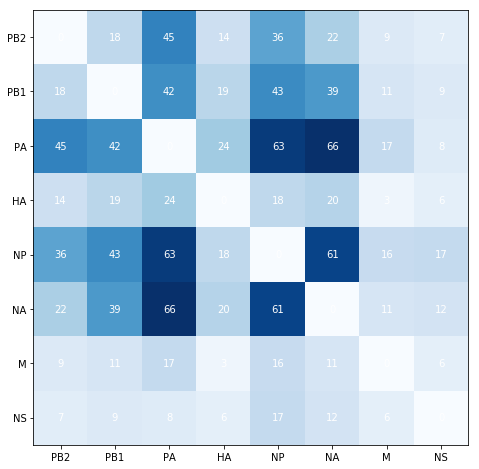

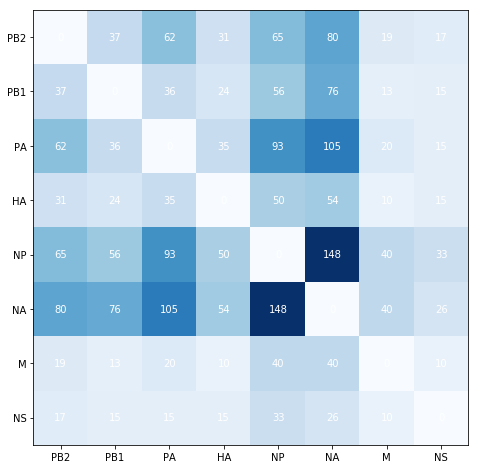

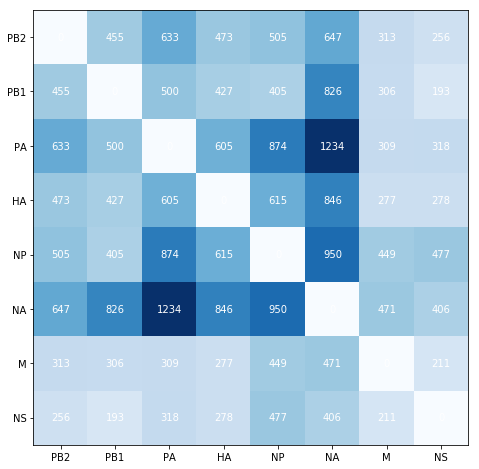

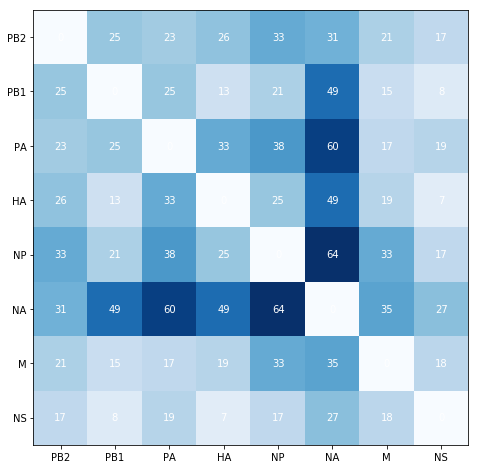

In [20]:
heatmap_dir = output_dir + '/figures/original/intersegmental_heatmaps'
!mkdir -p $heatmap_dir
for sample in samples:
    interseg_file = output_dir + '/figures/original/circos/' + sample + '_inter.links'
    print(sample)
    m = getIntersegHeatMap(interseg_file, sample, heatmap_dir,
                           use_log_scale=False, use_abs_scale=True)
    makeCsvFromMatrix(m, heatmap_dir + '/' + sample + '.csv')
    print()

# Generate Circos Plots & Heatmaps for Shared Links

To clean up the Circos plots and have heatmaps representative of the strain instead of a specific replicate, we create link files that only contain interactions found in both replicates.

Similarly to how we compare links for Pearson, we generate binned matrices in order to determine whether links were found in both replicates. We toyed with several values (5, 10, 25, 50, 100) for the bin size and eventually settled on 25 as a reasonable representation of intersegmental interactions that isn't too cluttered. This can be changed via the `shared_bin_size` parameter at the top of the notebook. 

In [21]:
def getSharedLinksDf(link_files, window_size, chrom_file, only_link_ends=False):
    inter_link_matrix = {}
    for link_file in link_files:
        bin_dict = {}
        seg_lens = jpk_util.getChromSizes(chrom_file)
        for segment in seg_lens:
            bin_dict[segment] = contactPlots.getChromBins(seg_lens[segment], window_size)
        link_matrix = contactPlots.getBinnedLinkMatrix(link_file, bin_dict, seg_lens,
                                                       just_inter=True, only_link_ends=only_link_ends)
        inter_link_matrix[link_file] = link_matrix
    df_inter_subset = pd.DataFrame([x for x in inter_link_matrix.values()],
                        index=[x for x in inter_link_matrix.keys()]).transpose()
    strain_df = df_inter_subset[link_files]
    
    # There's probably a better way to do this, but this lambda will only get
    # rows from the dataframe where more than one column has a value for the
    # interaction. Since we only had two replicates, this will only pull rows
    # where both replicates had the interaction.
    shared_links_df = strain_df[
        strain_df.apply(lambda row:
                       sum([1 if x > 0 else 0 for x in row]) > 1,
                       axis=1)]
    
    # For the histograms to be correct, we want to get the sum of interactions
    # between the replicates for shared interactions.
    final_df = shared_links_df.apply(
        lambda row:sum([x for x in row]),
        axis=1)
    
    return (final_df, bin_dict)

In [22]:
def makeLinksFile(out_file_name, df, chrom_file, bin_dict):
    seg_lens = jpk_util.getChromSizes(chrom_file)
    f_out = open(out_file_name, 'w+')
    for i, num_exps in enumerate(df):
        link = df.index[i]
        tup1, tup2 = link.split('-')
        seg1, bin1 = tup1.split(':')
        next_bin = int(bin1) + 1
        end1 = seg_lens[seg1]
        if len(bin_dict[seg1]) > next_bin:
            end1 = bin_dict[seg1][next_bin] - 1
        st1 = bin_dict[seg1][int(bin1)]

        seg2, bin2 = tup2.split(':')
        next_bin = int(bin2) + 1
        end2 = seg_lens[seg2]
        if len(bin_dict[seg2]) > next_bin:
            end2 = bin_dict[seg2][next_bin] - 1
        st2 = bin_dict[seg2][int(bin2)]

        out_line = '\t'.join([seg1, str(st1), str(end1),
            seg2, str(st2), str(end2)])
        print(out_line, file=f_out)
    f_out.close()

In [23]:
def getSharedLinks(link_files, window_size, strain, out_dir, only_link_ends=False):
    '''
    This creates the link files & the Circos plot
    
    link_files should be a list
    '''
    first_sample = [x for x in samples if strains[x] == strain][0]
    chrom_file = chroms[first_sample]
    
    df, bin_dict = getSharedLinksDf(link_files, window_size, chrom_file, only_link_ends)
    
    !mkdir -p $out_dir"/circos"
    shared_links_file = (out_dir + '/circos/' + strain + '_shared_' +
                         str(window_size) + '_inter.links')
    if only_link_ends:
        shared_links_file = shared_links_file.replace('_inter.links',
                                                      '_justJuncs_inter.links')
    makeLinksFile(shared_links_file, df, chrom_file, bin_dict)

    circos_pref = (strain + '_shared_' + str(window_size))
    if only_link_ends:
        circos_pref = circos_pref + '_justJuncs'
    circos.runCircosFromLinks(shared_links_file,
                              dir=out_dir,
                              prefix=circos_pref,
                              chrom_size_file=chrom_file,
                              ribbon=False, colored=False,
                              fromJuncs=False)

In [24]:
!mkdir -p $output_dir"/figures/shared/entire_reads"
for strain in unique_strains:
    link_files = [(output_dir + '/figures/original/links/' + x + '_links.txt')
        for x in samples if strains[x] == strain]
    for window_size in [shared_bin_size]: #[5, 10, 25, 50]:
        print('Strain = ' + strain + '; Bin = ' + str(window_size))
        getSharedLinks(link_files, window_size, strain, output_dir +
                       '/figures/shared/entire_reads')

Strain = NP_Hotspot; Bin = 25
Strain = WSN; Bin = 25


In [25]:
#!open $output_dir"/figures/shared/entire_reads/circos/"*shared*.png

NP_Hotspot, bin=25

WSN, bin=25



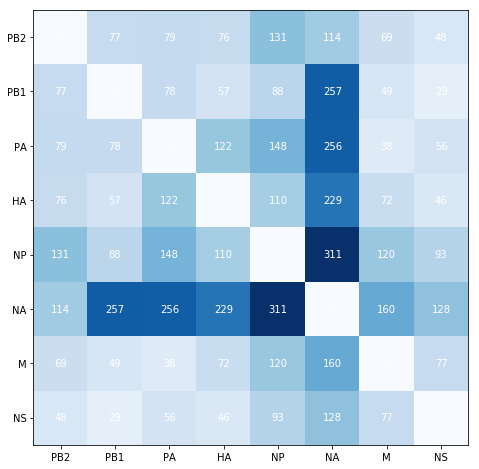

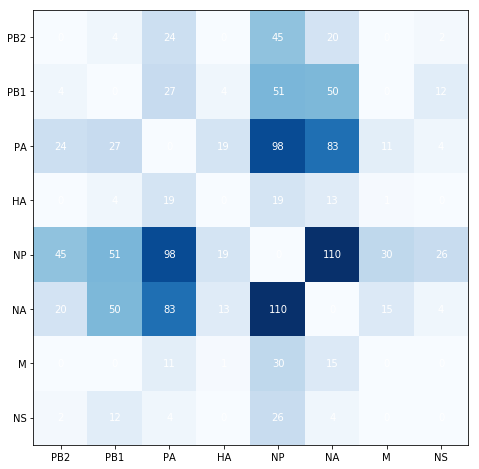

In [26]:
heatmap_dir = (output_dir + '/figures/shared/entire_reads/intersegmental_heatmaps')
!mkdir -p $heatmap_dir
for strain in unique_strains:
    for window_size in [shared_bin_size]: #[5, 10, 25, 50]:
        interseg_file = (output_dir +
                         '/figures/shared/entire_reads/circos/' +
                         strain + '_shared_' + str(window_size) +
                         '_inter.links')
        print(strain + ', bin=' + str(window_size))
        prefix = strain + '_' + str(window_size)
        
        m = getIntersegHeatMap(interseg_file, prefix, heatmap_dir,
                               use_log_scale=False, use_abs_scale=True)
        makeCsvFromMatrix(m, heatmap_dir + '/' + prefix + '.csv')
        print()